Author: Mike Stanley <br>
Created: 9/8/2018

Before we can actually implement a dirichlet process on higher dimensional data, we make sure we know how to deal with higher dimensional data in a typical GMM setting

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Generate Data

We generate data from the following distribution: <br>
$p \sim Dir(1, 1, 1)$ <br>
$z_i \sim Mult(p)$ <br>
$\mu_i \sim N(0, 10)$ <br>
$\Sigma \sim $ <br>
$x_i \vert z_i \sim N(\mu_i, \Sigma_i)$ 

In [2]:
# constants for the data generating process
CLUST_NUM = 3 # number of clusters
NUM_DATA = 1000 # number of data points

In [4]:
# distributions
dist0=stats.multivariate_normal(mean=[3, 3], cov=[[1., 0.],
                                                  [0., 1.]])
dist1=stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.],
                                                  [0., 1.]])
dist2=stats.multivariate_normal(mean=[3, 0], cov=[[1., 0.],
                                                  [0., 1.]])

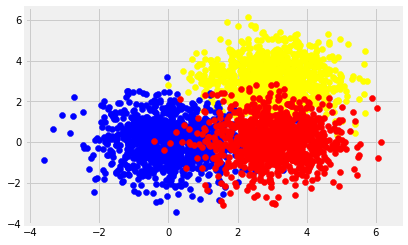

In [5]:
# see how the data looks
data0 = dist0.rvs(size=1000)
data1 = dist1.rvs(size=1000)
data2 = dist2.rvs(size=1000)
plt.scatter(data0[:,0], data0[:,1], color='yellow', label='cluster 0')
plt.scatter(data1[:,0], data1[:,1], color='blue', label='cluster 1')
plt.scatter(data2[:,0], data2[:,1], color='red', label='cluster 2')
plt.show()

In [7]:
np.random.choice([0, 1, 2], p = [0.2, 0.5, 0.3], size=12)

array([1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 1, 1])

In [9]:
# pick the distributions
cluster_choice = np.random.choice([0, 1, 2], p = [0.2, 0.5, 0.3], size=NUM_DATA)

data_mix = np.zeros(shape=(NUM_DATA, 2))

for idx, i in enumerate(cluster_choice):
    if i == 0:
        data_mix[idx, :] = dist0.rvs(size=1)
    elif i == 1:
        data_mix[idx, :] = dist1.rvs(size=1)
    elif i == 2:
        data_mix[idx, :] = dist2.rvs(size=1)

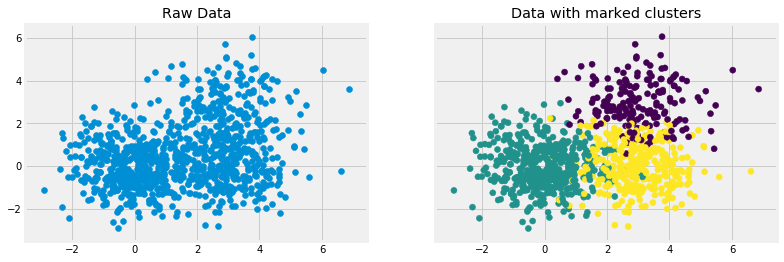

In [15]:
# plot the data
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(12, 4))
ax[0].scatter(data_mix[:, 0], data_mix[:, 1])
ax[0].set_title('Raw Data')

ax[1].scatter(data_mix[:, 0], data_mix[:, 1], c=cluster_choice)
ax[1].set_title('Data with marked clusters')

plt.show()

# Fit a model

In [91]:
with pm.Model() as model:
    
    # prior on multinomial parameters
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=CLUST_NUM)
    
    # make sure that every cluster has some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < 0.1, -np.inf, 0))
    
    # cluster means
    mu = pm.Normal('means', 0., 10., shape=(3, 2))
    
    # break symmetry
    order_mu_potential_01 = pm.Potential('order_mu_potential_01', 
                                         tt.switch(mu[1] - mu[0] < 0., -np.inf, 0))
    order_mu_potential_12 = pm.Potential('order_mu_potential_12',
                                         tt.switch(mu[2] - mu[1] < 0., -np.inf, 0))
    
    # cluster covariances
    #packed_L_0 = pm.LKJCholeskyCov('packed_L_0', n=2, eta=2.,
    #                               sd_dist=pm.HalfCauchy.dist(2.5))
    #L_0 = pm.expand_packed_triangular(n=2, packed=packed_L_0)
    #sigma_0 = pm.Deterministic('Sigma_0', L_0.dot(L_0.T))
    
    #packed_L_1 = pm.LKJCholeskyCov('packed_L_1', n=2, eta=2.,
    #                               sd_dist=pm.HalfCauchy.dist(2.5))
    #L_1 = pm.expand_packed_triangular(n=2, packed=packed_L_1)
    #sigma_1 = pm.Deterministic('Sigma_1', L_1.dot(L_1.T))
    
    #packed_L_2 = pm.LKJCholeskyCov('packed_L_2', n=2,  eta=2., 
    #                               sd_dist=pm.HalfCauchy.dist(2.5))
    #L_2 = pm.expand_packed_triangular(n=2, packed=packed_L_2)
    #sigma_2 = pm.Deterministic('Sigma_2', L_2.dot(L_2.T))
    
    # put the above into a dictionary
    #L_dict = {
    #    0:L_0,
    #    1:L_1,
    #    2:L_2
    #}
    
    # latent cluster of each observation
    cluster = pm.Categorical('cluster', p=p, shape=NUM_DATA)
    
    # observation likelihood
    obs = pm.MvNormal('obs', mu=mu[cluster], cov=np.array([[1., 0.], [0., 1.]]), observed=data_mix)
    

In [92]:
# sample
with model:
    step1 = pm.Metropolis(vars=[p, mu])
    step2 = pm.ElemwiseCategorical(vars=[cluster], values=np.arange(CLUST_NUM))
    trace_ = pm.sample(draws=20000, step=[step1, step2])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [p]
>ElemwiseCategorical: [cluster]
Sampling 2 chains: 100%|██████████| 41000/41000 [08:53<00:00, 76.87draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [93]:
# the trace
trace = trace_[10000::10]

In [94]:
# look at the first cluster...should have mean (3, 3)
trace['means'][:, 0, :].mean(axis=0)

array([ 0.0563932 , -0.17931237])

In [95]:
# look at the first cluster...should have mean (3, 3)
trace['means'][:, 1, :].mean(axis=0)

array([1.57831408, 0.49782637])

In [96]:
# look at the first cluster...should have mean (3, 3)
trace['means'][:, 2, :].mean(axis=0)

array([3.03785319, 2.10226934])

In [97]:
trace['p'].mean(axis=0)

array([0.46314269, 0.21846205, 0.31839526])

In [98]:
np.bincount(trace['cluster'][:,0]) / 2000

array([0.889, 0.108, 0.003])

In [89]:
cluster_choice

array([1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0,
       2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1,
       1, 1, 2, 0, 0, 1, 2, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1,
       2, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2,
       1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 1, 1, 2,
       2, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2,
       1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0,

# Austin Rochford, again with the solution!

Link here: https://gist.github.com/AustinRochford/41109579c8be23a10e2cd167209dbe25

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Generating Functions

In [8]:
def n_triu(d):
    return (d-1)*d/2

def n_triu_inv(t, module=np):
    return int(1/2*(1 + module.sqrt(1 + 8*t)))

def make_cov_matrix(sigmas, C_triu, module=np):
    D = len(sigmas.tag.test_value if hasattr(sigmas, "tag") else sigmas)
    C = module.ones((D,D))
    Sigmas = module.diag(sigmas)
    # indices are always numpy
    idxu = np.triu_indices(D, 1)
    idxl = np.tril_indices(D, -1)
    if module.__name__ == "theano.tensor":
        C = tt.set_subtensor(C[idxu], C_triu)
        C = tt.set_subtensor(C[idxl], C_triu)
    elif module.__name__ == "numpy":
        C[idxu] = C_triu
        C[idxl] = C_triu
    return Sigmas.dot(C).dot(Sigmas)

# Generate Data

In [127]:
D = 2 # dimension of data
K = 3 # number of clusters

mus = np.random.normal(scale=3, size=(K, D)) # randomly select centers
sigmas = np.random.uniform(high=1, size=(K, D)) # randomly select stds
covariances = np.empty((K, D, D))

for k in range(K):
    corr = np.random.uniform(low=-1, high=1, size=int(n_triu(D)))
    covariances[k] = make_cov_matrix(sigmas[k], corr)

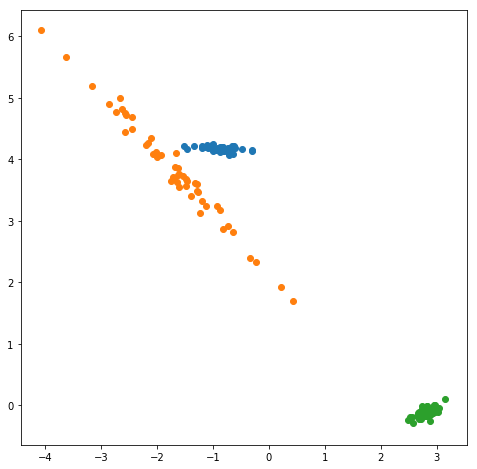

In [13]:
# plot the above generated data
N_samples = 50
plt.figure(figsize=(8, 8))
data = []
for mu, cov in zip(mus, covariances):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    data.append(nxy)
    plt.scatter(nxy[:, 0], nxy[:, 1])
    
data = np.concatenate(data)

# Model

In [17]:
# get initial estimates
init_mean = np.mean(data, axis=0)
init_sigma = np.std(data, axis=0).astype(np.float32) / 10
idxu = np.triu_indices(D, 1)
init_corr = np.corrcoef(data, rowvar=0)[idxu].astype(np.float32)

In [20]:
def multivariatenormal(init_mean, init_sigma, init_corr, suffix='', dist=False):
    if not isinstance(suffix, str):
        suffix = str(suffix)
    D = len(init_sigma)
    
    sigma = pm.Lognormal('sigma' + suffix, 
                         np.zeros(D, dtype=np.float), np.ones(D), 
                         shape=D, 
                         testval=init_sigma)
    nu = pm.Uniform('nu'+suffix, 0, 5)
    C_triu = pm.LKJCorr('C_triu'+suffix, nu, D, testval=init_corr)
    cov = pm.Deterministic('cov'+suffix, make_cov_matrix(sigma, C_triu, module=tt))
    
    mu = pm.MvNormal('mu'+suffix, 0, cov, shape=2, testval=init_mean)
    
    return pm.MvNormal.dist(mu, cov) if dist else pm.MvNormal('mvn' + suffix, mu, cov)

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [21]:
K = 3
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones(K))
    obs = pm.Mixture('obs', w, [multivariatenormal(init_mean,
                                                   init_sigma,
                                                   init_corr,
                                                   suffix=k,
                                                   dist=True) for k in range(K)], 
                     observed=data)

In [22]:
w.tag.test_value

array([0.33333333, 0.33333333, 0.33333333])

In [23]:
# sample
with model:
    trace = pm.sample(10000, pm.Metropolis())[5000::5]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu2]
>Metropolis: [C_triu2]
>Metropolis: [nu2]
>Metropolis: [sigma2]
>Metropolis: [mu1]
>Metropolis: [C_triu1]
>Metropolis: [nu1]
>Metropolis: [sigma1]
>Metropolis: [mu0]
>Metropolis: [C_triu0]
>Metropolis: [nu0]
>Metropolis: [sigma0]
>Metropolis: [w]
Sampling 2 chains: 100%|██████████| 21000/21000 [04:02<00:00, 86.68draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


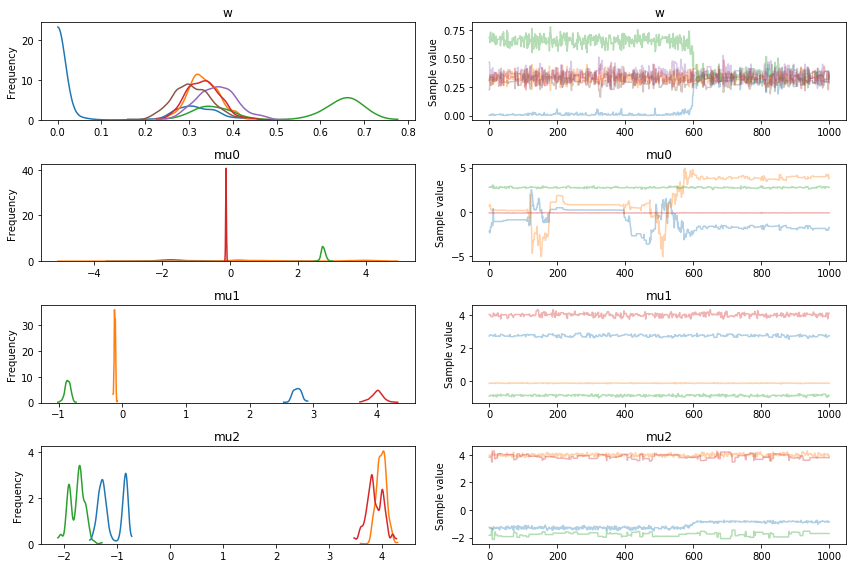

In [24]:
pm.traceplot(trace, varnames=["w", 'mu0', 'mu1', 'mu2']);

# Plot the learned distributions

In [46]:
# learned dist parameters
mu_learned = np.stack([trace['mu0'].mean(axis=0), trace['mu1'].mean(axis=0), trace['mu2'].mean(axis=0)])
cov_learned = np.stack([trace['cov0'].mean(axis=0), trace['cov1'].mean(axis=0), trace['cov2'].mean(axis=0)])

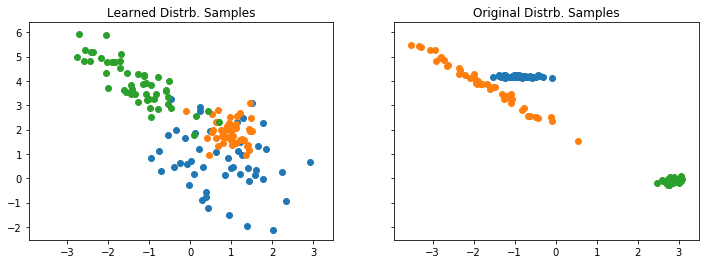

In [62]:
# plot the above generated data vs. the actual data
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))

# learned distributions
N_samples = 50
data_learned = []
for mu, cov in zip(mu_learned, cov_learned):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    data_learned.append(nxy)
    ax[0].scatter(nxy[:, 0], nxy[:, 1])
    
data_learned = np.concatenate(data_learned)

# original distribution sampling
for mu, cov in zip(mus, covariances):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    ax[1].scatter(nxy[:, 0], nxy[:, 1])
    
# labeling
ax[0].set_title('Learned Distrb. Samples')
ax[1].set_title('Original Distrb. Samples')

plt.show()

# Simply the above

We look at a situation where there is no off-diagonal correlation

In [161]:
def make_cov_matrix_no_corr(sigma, module=tt):
    '''
    similar to the other make_cov_matrix function, but assumes there 
    is no off diagonal correlation
    '''
    return module.diag(sigma)

### Generate Data

In [166]:
D = 2 # dimension of data
K = 3 # number of clusters

mus = np.random.normal(scale=3, size=(K, D)) # randomly select centers
sigmas = np.random.uniform(high=1, size=(K,2)) # randomly select stds
covariances = np.empty((K, D, D))

for k in range(K):
    covariances[k] = make_cov_matrix_no_corr(sigmas[k], module=np)

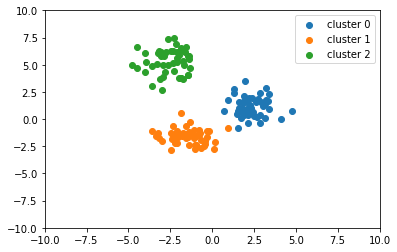

In [167]:
# make data and plot the above distributions
N_samples = 50 # keep this number the same for now to make sure any improves in accuracy are just model related
data_learned_simp = []

for idx, (mu, cov) in enumerate(zip(mus, covariances)):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    data_learned_simp.append(nxy)
    plt.scatter(nxy[:, 0], nxy[:, 1], label='cluster %i' % idx)
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend(loc='best')
    
data_learned_simp = np.concatenate(data_learned_simp)

### Fit model

In [168]:
def multivariatenormal_simp(init_mean, init_sigma, suffix='', dist=False):
    if not isinstance(suffix, str):
        suffix = str(suffix)
    D = len(init_mean)
    
    sigma = pm.Lognormal('sigma' + suffix, 
                         0., 1., 
                         shape=2, testval=init_sigma)
    #sigma = pm.Gamma('sigma'+suffix, 1., 1., shape=2)
    cov = pm.Deterministic('cov'+suffix, make_cov_matrix_no_corr(sigma, module=tt))
    
    mu = pm.MvNormal('mu'+suffix, 0, cov, shape=2, testval=init_mean)
    
    return pm.MvNormal.dist(mu, cov) if dist else pm.MvNormal('mvn' + suffix, mu, cov)

In [169]:
# come up with some initial estimates
init_mean = data_learned_simp.mean(axis=0)
init_sigma = data_learned_simp.std(axis=0)

In [170]:
K = 3
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones(K))
    obs = pm.Mixture('obs', w, [multivariatenormal_simp(init_mean,
                                                        init_sigma,
                                                        suffix=k,
                                                        dist=True) for k in range(K)], 
                     observed=data)

In [171]:
with model:
    trace = pm.sample(10000, pm.Metropolis())[5000::5]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu2]
>Metropolis: [sigma2]
>Metropolis: [mu1]
>Metropolis: [sigma1]
>Metropolis: [mu0]
>Metropolis: [sigma0]
>Metropolis: [w]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:32<00:00, 226.17draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Explore output

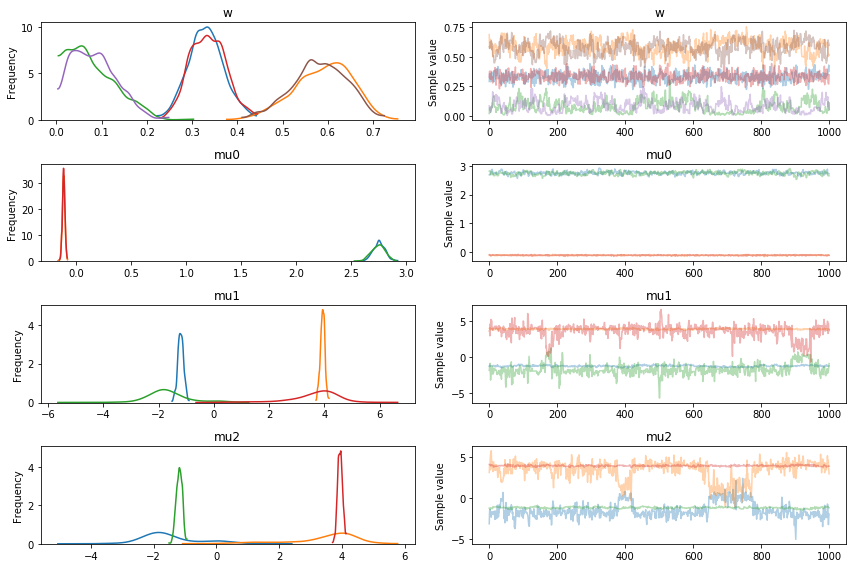

In [172]:
pm.traceplot(trace, varnames=["w", 'mu0', 'mu1', 'mu2']);

In [189]:
# learned parameters
mu_learned_simp = np.stack([trace['mu0'].mean(axis=0), trace['mu1'].mean(axis=0), trace['mu2'].mean(axis=0)])
cov_learned_simp = np.stack([trace['cov0'].mean(0), trace['cov1'].mean(0), trace['cov2'].mean(0)])

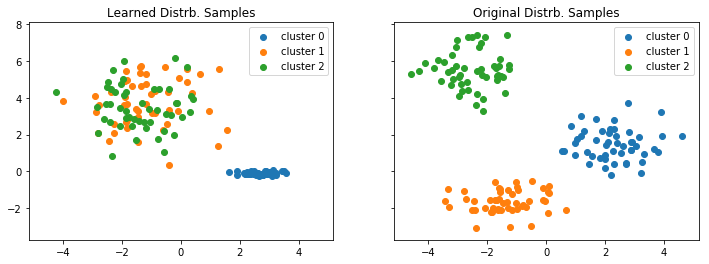

In [192]:
# plot the above generated data vs. the actual data
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))

# learned distributions
N_samples = 50
data_learned = []
for idx, (mu, cov) in enumerate(zip(mu_learned_simp, cov_learned_simp)):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    data_learned.append(nxy)
    ax[0].scatter(nxy[:, 0], nxy[:, 1], label='cluster %i' %idx)
    
data_learned = np.concatenate(data_learned)

# original distribution sampling
for idx, (mu, cov) in enumerate(zip(mus, covariances)):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype('float32')
    ax[1].scatter(nxy[:, 0], nxy[:, 1], label='cluster %i' %idx)
    
# labeling
ax[0].set_title('Learned Distrb. Samples')
ax[1].set_title('Original Distrb. Samples')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.show()